# Testing the Bars library

In [1]:
from bars import Bars
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, normaltest
import statsmodels.api as sm
from itertools import product

## Downloading data.

Load price data from Yahoo finance

In [2]:
ticker = 'JPM'
period, interval = '30y', '1d'

In [3]:
price_data = yf.Ticker(ticker).history(period=period, interval=interval)
price_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1993-12-13,5.395415,5.412653,5.326464,5.412653,2002500,0.0,0.0
1993-12-14,5.412655,5.412655,5.291991,5.378180,1865400,0.0,0.0
1993-12-15,5.378177,5.429890,5.343702,5.343702,2073000,0.0,0.0
1993-12-16,5.360940,5.498843,5.360940,5.360940,2198100,0.0,0.0
1993-12-17,5.429892,5.464367,5.378178,5.464367,3737100,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-06,158.839996,159.220001,156.000000,156.309998,9366000,0.0,0.0
2023-12-07,156.690002,157.309998,156.149994,156.789993,8130900,0.0,0.0
2023-12-08,157.259995,158.779999,156.979996,158.520004,7366200,0.0,0.0


The Bars class needs a dataframe indexed by date which has the column 'Volume' and 'Price' 

In [4]:
selected_columns = price_data[['Volume', 'Close']].copy()
selected_columns.rename(columns={'Close': 'Price'}, inplace=True)
selected_columns

,Volume,Price
Date,,
1993-12-13,2002500,5.412653
1993-12-14,1865400,5.378180
1993-12-15,2073000,5.343702
1993-12-16,2198100,5.360940
1993-12-17,3737100,5.464367
...,...,...
2023-12-06,9366000,156.309998
2023-12-07,8130900,156.789993
2023-12-08,7366200,158.520004


Plot price over time

<AxesSubplot: xlabel='Date'>

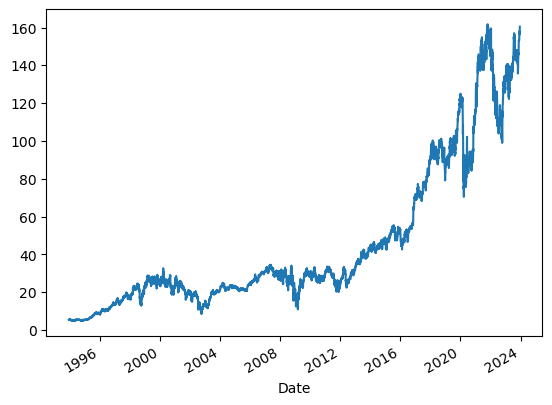

In [5]:
selected_columns['Price'].plot()

Plot volume over time

<AxesSubplot: xlabel='Date'>

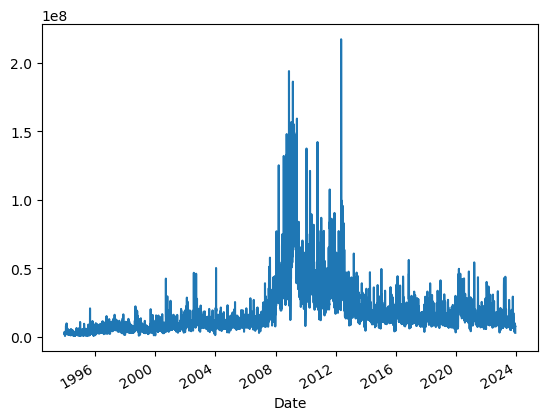

In [6]:
selected_columns['Volume'].plot()

## Bars

In [7]:
id_time_sampling = selected_columns[::10].index

In [8]:
target_samples_per_day = 1/10
beta = 10000
bar_types = ['tick', 'volume', 'dollar']
imbalance_signs = [False, True]

In [9]:
id_bars = []

In [10]:
for imbalance_sign, bar_type in product(imbalance_signs, bar_types):
    bars = Bars(bar_type, imbalance_sign, target_samples_per_day, beta)
    temp = bars.get_all_bar_ids(selected_columns)
    id_bars.append(temp)

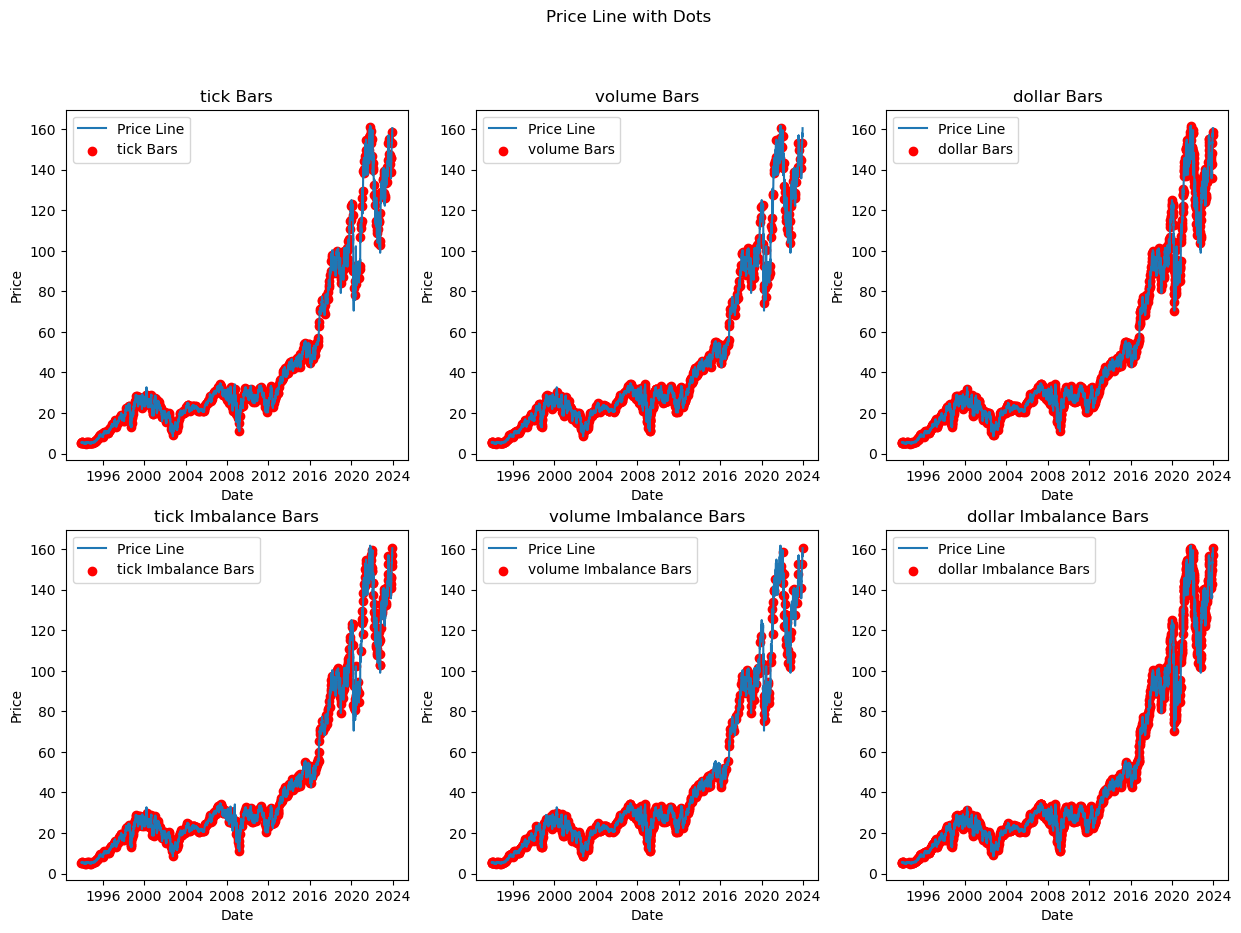

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle('Price Line with Dots')

for i, (ax, (imbalance_sign, bar_type)) in enumerate(zip(axes.flatten(), product(imbalance_signs, bar_types))):    
    ax.plot(selected_columns['Price'], label='Price Line')
    ax.scatter(id_bars[i], selected_columns['Price'].loc[id_bars[i]], label=f'{bar_type}{" Imbalance" if imbalance_sign else ""} Bars', color='red')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.set_title(f'{bar_type}{" Imbalance" if imbalance_sign else ""} Bars')
    ax.legend()

### Normality of returns

First we find the returns using time based sampling and plot the quantile–quantile plot of returns. We see the 'fat-tails' that are typical for returns of financial instruments. 

In [12]:
returns_time = selected_columns.loc[id_time_sampling]['Price'].pct_change().dropna()

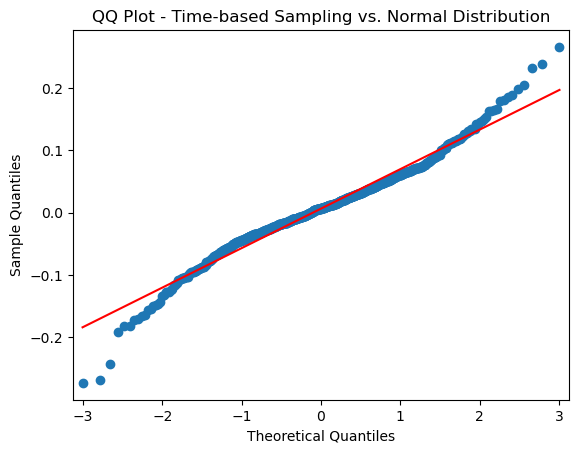

In [13]:
fig, ax = plt.subplots()
sm.qqplot(returns_time, line='s', ax=ax)
ax.set_title('QQ Plot - Time-based Sampling vs. Normal Distribution')
plt.show()

In [14]:
returns_bars = [selected_columns.loc[idx]['Price'].pct_change().dropna() for idx in id_bars]

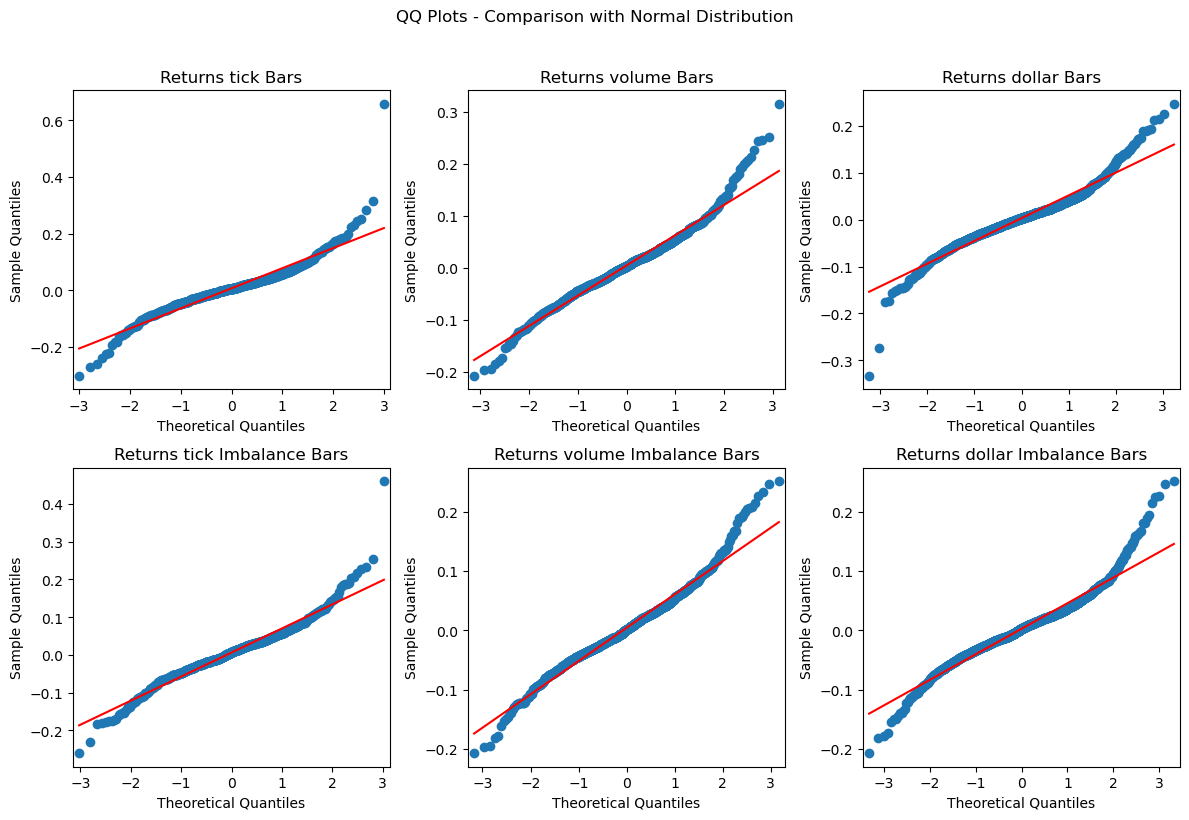

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('QQ Plots - Comparison with Normal Distribution', y=1.02)
axes = axes.flatten()

for i, (imbalance_sign, bar_type) in enumerate(product(imbalance_signs, bar_types)):
    ax = axes[i]
    sm.qqplot(np.array(returns_bars[i]), line='s', ax=ax)
    ax.set_title(f'Returns {bar_type}{" Imbalance" if imbalance_sign else ""} Bars')

plt.tight_layout()
plt.show()

The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution. 

In [16]:
print('P-value for Shapiro-Wilk normality test for time-based sampling returns: ', shapiro(returns_time.values).pvalue)

P-value for Shapiro-Wilk normality test for time-based sampling returns:  1.0058346516794714e-10


Now we create a heatmap of the p-values for all the bars variants. 

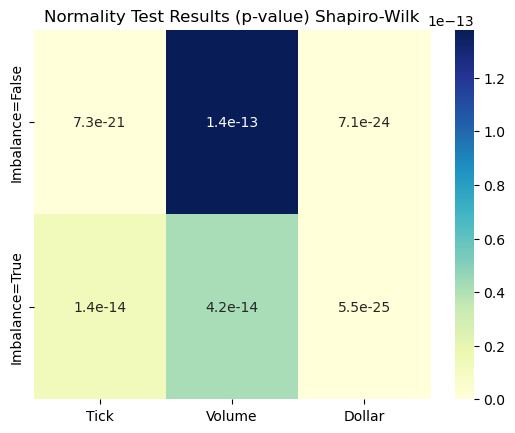

In [22]:
normaltest_results = [shapiro(rb.values) for rb in returns_bars]
p_values = [result.pvalue for result in normaltest_results]
p_values_2d = [p_values[i:i+3] for i in range(0, len(p_values), 3)]
sns.heatmap(p_values_2d, annot=True, cmap="YlGnBu", xticklabels=['Tick', 'Volume', 'Dollar'], yticklabels=['Imbalance=False', 'Imbalance=True'])
plt.title('Normality Test Results (p-value) Shapiro-Wilk')
plt.show()

D'Agostino's K^2 test for normality 

In [23]:
print('P-value for D\'Agostino\'s K^2 normality test for time-based sampling returns: ', normaltest(returns_time.values).pvalue)

P-value for D'Agostino's K^2 normality test for time-based sampling returns:  2.6184217805507984e-10


Now we create a heatmap of the p-values for all the bars variants. 

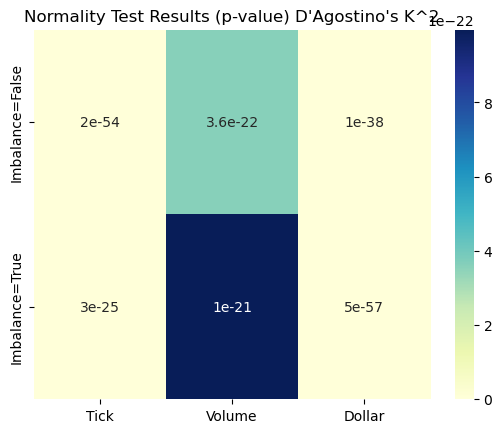

In [24]:
normaltest_results = [normaltest(rb.values) for rb in returns_bars]
p_values = [result.pvalue for result in normaltest_results]
p_values_2d = [p_values[i:i+3] for i in range(0, len(p_values), 3)]
sns.heatmap(p_values_2d, annot=True, cmap="YlGnBu", xticklabels=['Tick', 'Volume', 'Dollar'], yticklabels=['Imbalance=False', 'Imbalance=True'])
plt.title('Normality Test Results (p-value) D\'Agostino\'s K^2')
plt.show()

We see that since all values are smaller than $\alpha=0.05$ we reject the null hypothesis i.e. we have sufficient evidence to say that sample does not come from a normal distribution. This is expected since the litterature tells us that bars sampling can make returns slightly closer to normal, but not normal. 

### Autocorrelation

Pearson correlation coefficient. Testing significantly non-zero autocorrelation. 
* $r=1$: Perfect positive linear correlation. As one variable increases, the other variable increases proportionally.
* $r=−1$: Perfect negative linear correlation. As one variable increases, the other variable decreases proportionally.
* $r≈0$: No linear correlation. There is no systematic linear relationship between the variables.

In [25]:
print('Pearsons correlation coefficient for time-based sampling returns: ', np.corrcoef(returns_time.values[:-1], returns_time.values[1:])[0][1])

Pearsons correlation coefficient for time-based sampling returns:  -0.048295717433238496


Now we create a heatmap of the pearsons correlation coefficient for all the bars variants. 

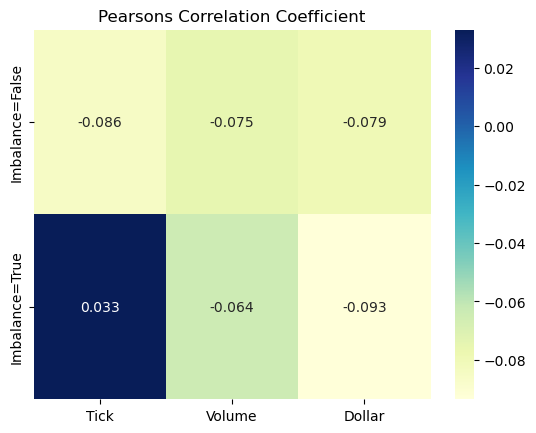

In [27]:
results = [np.corrcoef(rb.values[:-1], rb.values[1:])[0][1] for rb in returns_bars]
results_2d = [results[i:i+3] for i in range(0, len(results), 3)]
sns.heatmap(results_2d, annot=True, cmap="YlGnBu", xticklabels=['Tick', 'Volume', 'Dollar'], yticklabels=['Imbalance=False', 'Imbalance=True'])
plt.title('Pearsons Correlation Coefficient')
plt.show()